In [ ]:
import numpy.random as rand
import numpy as np
import numpy.linalg as la
import timeit
import time
from numpy.linalg import inv
import scipy.stats as stats
import heapq
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from collections import deque


# **Organization of the file**

The code can be broadly classified in three parts:
1.   The fist part focuses on implementing graph theoretic functions like the minimum spanning tree, equivalence class, etc.
2.   In the second part implements the generation of the samples and other quantities which are empirically estimated.
3.   The third part contains the all the nuts and bolts of our algorithm as well as the complete execution of the algorithm.


To run the code, set the desired parameters in the init_paramters() function. Then, call the main() function.


# **Graph structure algorithms section**




In [ ]:
"""
Minimum Spanning Tree subroutine borrowed from : https://www.geeksforgeeks.org/kruskals-minimum-spanning-tree-algorithm-greedy-algo-2/
"""
# Minimum Spanning Tree of a given connected,
# undirected and weighted graph
 
from collections import defaultdict
 
# Class to represent a graph
 
 
class Graph:
 
    def __init__(self, vertices):
        self.V = vertices  # No. of vertices
        self.graph = []  # default dictionary
        # to store graph
 
    # function to add an edge to graph
    def addEdge(self, u, v, w):
        self.graph.append([u, v, w])
 
    # A utility function to find set of an element i
    # (uses path compression technique)
    def find(self, parent, i):
        if parent[i] == i:
            return i
        return self.find(parent, parent[i])
 
    # A function that does union of two sets of x and y
    # (uses union by rank)
    def union(self, parent, rank, x, y):
        xroot = self.find(parent, x)
        yroot = self.find(parent, y)
 
        # Attach smaller rank tree under root of
        # high rank tree (Union by Rank)
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
 
        # If ranks are same, then make one as root
        # and increment its rank by one
        else:
            parent[yroot] = xroot
            rank[xroot] += 1
 
    # The main function to construct MST using Kruskal's
        # algorithm
    def KruskalMST(self):
 
        result = []  # This will store the resultant MST
         
        # An index variable, used for sorted edges
        i = 0
         
        # An index variable, used for result[]
        e = 0
 
        # Step 1:  Sort all the edges in 
        # non-decreasing order of their
        # weight.  If we are not allowed to change the
        # given graph, we can create a copy of graph
        self.graph = sorted(self.graph, 
                            key=lambda item: item[2])
 
        parent = []
        rank = []
 
        # Create V subsets with single elements
        for node in range(self.V):
            parent.append(node)
            rank.append(0)
 
        # Number of edges to be taken is equal to V-1
        while e < self.V - 1:
 
            # Step 2: Pick the smallest edge and increment
            # the index for next iteration
            u, v, w = self.graph[i]
            i = i + 1
            x = self.find(parent, u)
            y = self.find(parent, v)
 
            # If including this edge does't
            #  cause cycle, include it in result 
            #  and increment the indexof result 
            # for next edge
            if x != y:
                e = e + 1
                result.append([u, v])
                self.union(parent, rank, x, y)
            # Else discard the edge
 
        return result
 

In [ ]:
class Tree:

    def __init__(self, num_nodes, shape):
        self.num_nodes = num_nodes
        self.shape = shape
        self.edges = []
    
    """
    Given a matrix of pairwise mutual information, find the CL tree.

    Input:
    Pairwise mutual information matrix - mi_mat

    Output:
    List of edges for the maximum spanning tree.
    """
    def chow_liu_tree(self, mi_mat):
        g = Graph(self.num_nodes)
        for i in range(self.num_nodes-1):
            for j in range(i+1,self.num_nodes):
                g.addEdge(i, j, -mi_mat[i,j])
        return g.KruskalMST()


    """
    Given a shape argument, return the edges.

    Input:
    Tree shape that takes values among "star", "chain", "random" - shape 

    Output:
    Edges of the tree as a list of lists where each list has 2 nodes which have an edge - edges
    """
    def gen_edges(self):
        self.edges = []
        if self.shape == 'star':
            # Node 0 is the center node and the remaining nodes are connected to node 0.
            for i in range(self.num_nodes-1):
                self.edges.append([i+1,0])
        if self.shape == 'chain':
            # Edges between node i and i+1
            for i in range(self.num_nodes-1):
                self.edges.append([i,i+1])
        if self.shape == "random":
            # To get a random graph, generate an arbitrary weight matrix and find its spanning tree.
            rand_mat = rand.uniform(size = [self.num_nodes,self.num_nodes])
            self.edges = self.chow_liu_tree(rand_mat)


    """
    Convert a list of edges to adjacency matrix.

    Input:
    List of edges - list_edges

    Output:
    Adjacency Matrix - adj
    """
    def _edges_to_adj(self, list_edges):
        n = len(list_edges) + 1
        adj = np.zeros(shape=[n,n])
        for i in list_edges:
            adj[i[0], i[1]] = 1
            adj[i[1], i[0]] = 1
        return adj

    """
    Find leaf clusters from adjacency matrix. Also find the adjacency matrix for leaf clusters.

    Input:
    Adacency matrix for the edges - adj

    Output:
    A list of lists where each list contains the nodes within a leaf cluster - LC
    Adjacency matrix for the leaf clusters (two leaf clusters have an edge of there is an edge between the nodes in the leaf clusters) - LC_adj
    """
    def _adj_to_LC(self,adj):
        LC = []
        leaves = set([])
        for i in range(self.num_nodes):
            if sum(adj[i,:]) == 1:
                leaves.add(i)
        D = {}
        LC_edges = []
        for i in range(self.num_nodes):
            if i in leaves:
                continue
            D[i] = len(LC)
            LC.append([i])
            for j in range(self.num_nodes):
                if adj[i,j] == 1: 
                    if j in leaves:
                        LC[-1].append(j)
                    elif j in D:
                        LC_edges.append([D[i],D[j]])
        LC_adj = self._edges_to_adj(LC_edges)
        return LC,LC_adj

    """
    Generate the list of trees in the equivalence class from the leaf clusters and leaf cluster adjacency matrix.

    Input:
    Leaf Clusters - LC
    Leaf Cluster Adjacency Matrix - LC_adj
    """
    def _edges_lc_to_tree_set(self, LC, LC_adj):
        # If there is just one leaf cluster, return all the trees with each node taking turns being the parent node.
        if len(LC) == 1:
            trees = []
            for i in LC[0]:
                tree = [[]]
                tree[0].append(i)
                for j in LC[0]:
                    if i == j:
                        continue
                    tree.append([i,j])
                trees.append(tree)
            return trees
        len_LC = len(LC)
        # Obtain the equivalence class excluding the last leaf cluster.
        prev_trees = self._edges_lc_to_tree_set(LC[:-1], LC_adj[:-1, :-1])
        curr_LC = LC[-1]
        trees = []
        for tree in prev_trees:
            for j in LC[-1]:
                tree_copy = copy.deepcopy(tree)
                tree_copy[0].append(j)
                # Add edges within the last leaf cluster
                for k in LC[-1]:
                    if k == j:
                        continue
                    tree_copy.append([k,j])
                # Add edges between the last leaf cluster and its adjacent leaf clusters
                for i in range(len_LC):
                  if LC_adj[-1, i] == 1:
                    tree_copy.append([tree_copy[0][i], j])
                trees.append(tree_copy)
        return trees

    """
    Given a list of edges, find the list of trees in the Equivalence Class.

    Input: 
    List of Edges - edges

    Output:
    List of trees in the equivalence class - tree_list
    """
    def edges_to_EC(self):
        tree_list = []
        adj = self._edges_to_adj(self.edges)
        LC, LC_adj = self._adj_to_LC(adj)
        trees = self._edges_lc_to_tree_set(LC, LC_adj)
        for tree in trees:
            tree_edges = tree[1:]
            tree_list.append(set([frozenset(i) for i in tree_edges]))
        return tree_list


    """
    If the nodes were randomly relabeled before feeding in the algorithm, use this to obtain the original labels back.

    Input:
    List of relabeled edges - list_edges
    Permutation used to relabel the nodes - permutation

    Output:
    List of originally labeled edges - new_edges
    """
    def invert_permute(self, list_edges, permutation):
        new_edges = []
        for i in list_edges:
            new_edges.append([permutation[i[0]], permutation[i[1]]])
        return new_edges


    """
    Transform the edges from a list of lists to a set of sets for easy testing of equality of two trees.
    """
    def edges_as_set_of_sets(self, list_edges):
        edges_set = set([frozenset(i) for i in list_edges])
        return edges_set

# **Graphical Model Sampling**






In [ ]:
class MRF_sampling:

    def __init__(self, num_samples, lam_1, lam_2, q_max, edges):
        self.lam_1 = lam_1
        self.lam_2 = lam_2
        self.q_max = q_max
        self.edges = edges
        self.num_samples = num_samples
        self.num_nodes = len(edges) + 1
        self.cond_dists = []
        self.pmf = None
        self.prob_err = None
        self.clean_samples = None
        self.noisy_samples = None


    """
    Convert a sample from integer in [0, 2^d - 1) to a 'd' dimensional vector with elements in [0,1].

    Inputs: 
    Integer in [0, 2^d - 1) - i
    Dimension - self.num_nodes

    Output: 
    vector with elements in [0,1] - ans
    """
    def _num_to_vec(self, i):
        ans = [-1]*self.num_nodes
        for j in range(self.num_nodes):
            ans[self.num_nodes-1-j] = int(i%2)
            i = int(i/2)
        return tuple(ans)

    """
    Generate conditional distribution for adjacent nodes in a graphical model with d nodes such that the minimum eigenvalue of the 
    conditional distribution matrix is between lam_1 and lam_2. Their are d-1 conditional distributions with one for each edge.
    For each conditional distribution, we sample the minimum eigenvalue uniformly at random from [lam_1, lam_2]. We generate the
    conditional PMF matrix by generating a rank 2 matrix and then adding lam_min*I to the rank 2 matrix.

    Inputs:
    Number of nodes - num_nodes
    Minimum Eigenvalue range- lam_1, lam_2

    Output:
    List of num_nodes-1 conditional distributions - cond_dists
    """
    def gen_cond_dist(self):
        self.cond_dists = []
        lam_min_arr = rand.choice(np.linspace(self.lam_1, self.lam_2, self.num_nodes-1),size = self.num_nodes-1, replace = False)
        for i in range(self.num_nodes-1):
            temp = rand.uniform(size = [1,2])
            temp1 = np.zeros(shape = [2,2])
            temp1[0, :] = temp[:,:]
            temp1[1, :] = temp[:,:]
            lam_min = lam_min_arr[i]
            for i in range(2):
                temp1[i, :] = temp1[i, :]/sum(temp1[i,:])
            P_i_p1_cond_i = (lam_min)*np.identity(2) + (1-lam_min)*temp1
            self.cond_dists.append(P_i_p1_cond_i)
        
    """
    Given a list of edges, convert then into an adjacency list. Adjaceny list is a dictionary indexed by the nodes as keys and the values are the list of edges for each key.
    This enables us to perform efficient BFS which further enables efficient sampling from the graphical model.
    Input:
    List of edges - edges

    Output:
    Adjacency List - adj_l
    """
    def _edges_to_adj_list(self):
        adj_l = {}
        for i in self.edges:
            if i[0] not in adj_l:
                adj_l[i[0]] = [i[1]]
            else:
                adj_l[i[0]].append(i[1])
            if i[1] not in adj_l:
                adj_l[i[1]] = [i[0]]
            else:
                adj_l[i[1]].append(i[0])
        return adj_l
        
    """
    Given an adjacency list, this function returns the order in which the edges would be traversed if Breadth first search(BFS) is used to scan the nodes.
    For each node, we record the order in which it was traversed and which node was its parent node. This order is used when generating the PMF of the graphical model.
    It is also used when generating samples directly without generating the PMF.

    Input:
    Adjacency List: adj_l

    Output:
    Order of traversal: order
    """
    def _bfs(self, adj_l):
        q = deque()
        visited = [0]
        order = []
        q.append(0)
        iter = 0
        while(q):
            node = q.popleft()
            for i in adj_l[node]:
                if i in visited:
                    continue
                order.append([i, node, iter])
                q.append(i)
                visited.append(i)
                iter+=1
        return order

    """
    Given a configuration of the nodes, find its PMF. The idea is to assign the 0th node equal probability for each support. Then go in the order obtained from BFS to generate 
    probability conditioned on each node's parent.

    Inputs: 
    Configuration of the nodes - x
    Conditional distribution matrices - cond_dists
    Order of Traveral - order

    Output:
    PMF for a given configuration - prob
    """
    def _input_to_prob(self, x, order):
        prob = 1/2
        for i in order:
            prob *= self.cond_dists[i[2]][x[i[1]], x[i[0]]]
        return prob

    """
    Generate the PMF of a graphical model given a list of conditional PMFs and a list of edges.

    Input:
    List of conditional PMFs - cond_dists
    List of edges - edges

    Output:
    PMF vector - pmf
    """
      
    def gen_pmf(self):
        adj_l = self._edges_to_adj_list()
        order = self._bfs(adj_l)
        self.pmf = np.ones(2**self.num_nodes)
        vec_num_to_vec = np.vectorize(self._num_to_vec)
        x_mat = np.transpose(np.array(vec_num_to_vec(np.arange(2**self.num_nodes))))
        self.pmf = np.apply_along_axis(self._input_to_prob, 1, x_mat, order)
        self.pmf = self.pmf/sum(self.pmf)

    
    """
    Generate random samples given a probability mass function.

    Inputs: 
    Probability mass function - pmf, 
    Number of samples - num_samples
    Dimension - num_nodes

    Output: 
    Samples (shape - [num_samples x num_nodes] ) - clean_samples
    """

    def gen_clean_samples_1(self):
        samples = rand.choice(2**self.num_nodes, size = (self.num_samples,), replace = True, p = self.pmf)
        self.clean_samples = np.ones((self.num_samples, self.num_nodes))
        for i in range(len(samples)):
            self.clean_samples[i, :] = self._num_to_vec(samples[i])


    """
    Given a sample for 0th node, generate samples for the remaining nodes.

    Input:
    Sample for the 0th node - x
    List of conditional PMFs - cond_dists
    Order of traversal - order

    Output:
    A sample vector - sample

    """
    def _gen_samples_cond_0(self, x, order):
        sample = np.zeros(d, dtype = int)
        sample[0] = x
        for i in order:
            sample[i[0]] = rand.choice(2, p = self.cond_dists[i[2]][sample[i[1]],:])
        return sample


    """
    Given a list of conditional distributions and edges, sample from the graphical model. Note that in this process we don't calculate the complete PMF which is an operation
    exponential in the number of nodes.

    Input:
    List of conditional PMFs - cond_dists
    List of edges - edges
    Number of samples - num_samples

    Output:
    Graphical model samples - samples
    """
    def gen_clean_samples_2(self):
        adj_l = self._edges_to_adj_list(self.edges)
        order = self._bfs(adj_l)
        samples_0 = rand.choice(2, size=[self.num_samples,1])
        self.clean_samples = np.apply_along_axis(self._gen_samples_cond_0, 1, samples_0, order)



    """
    Given clean samples, this function returns the output when the clean samples pass through a 3-ary symmetric channel.

    Input: 
    Clean samples - samples (shape - [num_samples x num_nodes])
    Probability of error for each dimension - prob_err 

    Output:
    Noisy samples - noisy_samples
    """
    def gen_noisy_samples(self):
        prob_err = rand.uniform(0, self.q_max, size = (self.num_nodes,))
        self.noisy_samples = np.copy(self.clean_samples)
        random_samples = rand.choice(2, size = [self.num_samples, self.num_nodes])
        mask = np.zeros(shape = [self.num_samples, self.num_nodes], dtype=bool)
        for i in range(self.num_nodes):
            mask[:,i] = rand.choice(a = [True, False], p = [prob_err[i], 1-prob_err[i]], size = self.num_samples)
        self.noisy_samples[mask] = random_samples[mask]
    

# **Algorithm to recover the tree**

In [ ]:
class RecoverTree():

    def __init__(self, noisy_samples, permutation, thres_prox, thres_star):
        self.noisy_samples = noisy_samples
        self.num_nodes = noisy_samples.shape[1]
        self.num_samples = noisy_samples.shape[0]
        self.permutation = permutation
        self._thres_prox = thres_prox
        self._thres_star = thres_star
        self.emp_mut_info = None
        self._prox = None
        self._prox_set = None
        self._emp_distribution = None
        self._emp_exp_dist = None

    """
    Finds the empirical pairwise distribution from the samples.

    Inputs: 
    Samples from which the empirical distribution is calculated - samples
    Dimension - num_nodes

    Outputs:
    A num_nodes x num_nodes list of empirical PMF matrices where i,j entry is the joint distribution of i^th and j^th random variables - _emp_distribution
    """
    def _gen_sample_dist(self):
        self._emp_distribution = [[None for _ in range(self.num_nodes)]for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(self.num_nodes):
                P = np.zeros(shape = [2,2])
                for k1 in range(2):
                    for k2 in range(2):
                        mask = (self.noisy_samples[:,self.permutation[i]] == k1) & (self.noisy_samples[:,self.permutation[j]] == k2)
                        P[k1, k2] = np.mean(mask)
                self._emp_distribution[i][j] = P

    """
    Generate neighnorhood sets.

    Inputs:
    Empirical joint pairwise PMF - _emp_distribution

    Outputs:
    A list of lists where each list is the set of neighborhood nodes saved as a tuple - _prox
    A list of sets containing the nodes in every node's neighborhood - _prox_set

    """
    def _get_prox(self):
        bin_p = False       # This is a flag for debug printing
        self._prox = []
        self._prox_set = []
        for i in range(self.num_nodes):
            h = []
            s = set([])
            for j in range(self.num_nodes):
                if j==i:
                    continue
                exp_dist = abs(la.det(self._emp_distribution[i][j]))/np.sqrt(la.det(self._emp_distribution[i][i])*la.det(self._emp_distribution[j][j]))
                if bin_p:
                    print(exp_dist, self._thres_prox)
                if exp_dist > self._thres_prox:
                    heapq.heappush(h, (-abs(exp_dist), j))
                    s.add(j)
            self._prox.append(h)
            self._prox_set.append(s)
  
    """
    Finds the empirical pairwise exponential of negative distances given the empirical probability distribution.

    Input: 
    Pairwise empirical distribution - _emp_distribution

    Output -
    Empirical pairwise negative exponential distances - _emp_exp_distance

    """
    def _pairwise_exp_distance(self):
        self._emp_exp_distance = np.zeros(shape = [self.num_nodes,self.num_nodes])
        for i in range(self.num_nodes):
            for j in range(self.num_nodes):
                self._emp_exp_distance[i,j] = abs(la.det(self._emp_distribution[i][j]))/np.sqrt(la.det(self._emp_distribution[i][i])*la.det(self._emp_distribution[j][j]))


    """
    Finds the empirical pairwise mutual information given the empirical probability distribution. This is used when running the Chow-Liu Algorithm

    Input: 
    Pairwise empirical distribution - _emp_distribution

    Output:
    Empirical pairwise mutual information - emp_mut_info
    """
    def pairwise_mut_info(self):
        self.emp_mut_info = np.zeros(shape = [self.num_nodes,self.num_nodes])
        entropy = np.zeros(self.num_nodes)
        for i in range(self.num_nodes):
            for j in range(2):
                entropy[i] += -self._emp_distribution[i][i][j,j]*np.log2(self._emp_distribution[i][i][j,j])
        for i in range(self.num_nodes):
            for j in range(self.num_nodes):
                if i==j:
                    continue
                joint_entropy = 0
                for k1 in range(2):
                    for k2 in range(2):
                        joint_entropy += -self._emp_distribution[i][j][k1,k2]*np.log2(self._emp_distribution[i][j][k1,k2])
                self.emp_mut_info[i,j] = entropy[i] + entropy[j] - joint_entropy

    """
    Checks if a set of 4 nodes is non-star structured. If it is, it returns the separation of the nodes in 2 groups of 2 nodes each.

    Input:
    The empirical pairwise of all the nodes - _emp_dist
    The set of 4 nodes that are checked for star/non-star - nodes
    Output:
    If the set of 4 nodes is non-star or not - non_star
    If they are, return the two pairs - fin_pair1, fin_pair2
    If not return empty lists - [], []

    """
    def _is_non_star(self, nodes):
        bin_p = False       # This is a flag for debug printing.
        non_star = False
        fin_pair1 = [-1,-1]
        fin_pair2 = [-1,-1]
        for i in range(4):
            for j in range(4):
                if i == j:
                    continue
                pair1 = [nodes[i], nodes[j]]
                pair2 = list(set(nodes) - set(pair1))
                if bin_p:
                    print(pair1, pair2)
                    print((self._emp_exp_distance[pair1[0], pair2[0]]*self._emp_exp_distance[pair1[1], pair2[1]])/\
                          (self._emp_exp_distance[pair1[0], pair2[1]]*self._emp_exp_distance[pair1[1], pair2[0]]), self._thres_star)
                if (self._emp_exp_distance[pair1[0], pair2[0]]*self._emp_exp_distance[pair1[1], pair2[1]])/\
                    (self._emp_exp_distance[pair1[0], pair2[1]]*self._emp_exp_distance[pair1[1], pair2[0]]) > self._thres_star\
                    and (self._emp_exp_distance[pair1[0], pair2[0]]*self._emp_exp_distance[pair1[1], pair2[1]])/\
                    (self._emp_exp_distance[pair1[0], pair1[1]]*self._emp_exp_distance[pair2[0], pair2[1]])<self._thres_star:                
                    non_star = True
                    fin_pair1[:] = pair1[:]
                    fin_pair2[:] = pair2[:]
        if non_star == True:
            return non_star, fin_pair1, fin_pair2
        else:
            return non_star, [], []


    """
    Given the pairwise empirical distributions and 3 input nodes, find their center node in the unidentifiable case.

    Inputs:
    Empirical pairwise negative exponential distances - _emp_exp_distance
    Lists and sets of neighborhood nodes - _prox, _prox_set
    Three nodes - l, r, j

    Output:

    Candidate center nodes - center_cand
    """
    def _find_unidentifiable_center(self, l, r, j):
        bin_p = False           # This is a flag to turn on/off debug printing
        center_cand = [l,r,j]
        # if bin_p:
            # print(self._prox)
        for tup in self._prox[r]:
            i = tup[1]
            if i == l or i == j:
                continue
            if i not in self._prox_set[l] or i not in self._prox_set[j]:
                continue
            non_star, pair1, pair2 = self._is_non_star([i,l,r,j])
            if bin_p:
                print(self.permutation[i],self.permutation[l],self.permutation[r],self.permutation[j], "ilrj", non_star, pair1, pair2, "non_star, pair1, pair2")
            if non_star and i in pair1:
                pair1.remove(i)
                if pair1[0] in center_cand:
                    center_cand.remove(pair1[0])
            if non_star and i in pair2:
                pair2.remove(i)
                if pair2[0] in center_cand:
                    center_cand.remove(pair2[0])
        return center_cand


    """
    Finds a pair of leaf and parent nodes from a set of active set of nodes.

    Inputs: 

    Active set of nodes - nodes
    Set of previous parent nodes - parents

    Outputs: 
    Leaf node - r
    Parent node - l
    """
    def _find_leaf_parent(self, nodes, parents):
        bin_p = False               # This is a flag to turn on/off debug printing            
        # Arbitrarily choose a node r
        r = nodes[0]
        prox_copy = copy.deepcopy(self._prox)
        # Select closest valid l
        l = heapq.heappop(prox_copy[r])[1]
        while l not in nodes:
            if len(prox_copy[r]) == 0:
                return []
            l = heapq.heappop(prox_copy[r])[1]
        visited = set([l, r])
        fix_lr = False
        while(1):
            if len(prox_copy[r]) == 0:
                break
            # Choose a third node j
            j = heapq.heappop(prox_copy[r])[1]
            while j not in nodes or j in visited:
                if len(prox_copy[r]) == 0:
                    return [l,r]
                j = heapq.heappop(prox_copy[r])[1]
            visited.add(j)
            # Find the center node among l, r, j
            centers = self._find_unidentifiable_center(l,r,j)
            if bin_p:
                print(self.permutation[l],self.permutation[r],self.permutation[j], centers, "l,r,j, centers")
            # If there are more than one candidate centers, they have to be a leaf parent pair
            if len(centers)>1:
              # If the candidate center nodes are l and r, and in any previous iteration, we found the parent node among them, return them in the same order.
                if fix_lr and l in centers and r in centers:
                    return [l,r]
                parent_exists = False
                for i in centers:
                    # print(parents, centers)
                    if i in parents:
                        l = i
                        parent_exists = True
                    if parent_exists:
                        centers.remove(i)
                        r = centers[0]
                        return [l,r]
                # Arbitrarily return a leaf parent pair.
                return centers[0], centers[1]  
            # If r is the center node, shift both l and r      
            if r in centers:
                l, r = r,j
                fix_lr = True
            # If j is the center node, shift l
            elif j in centers:
                l = j
                fix_lr = True
            elif l in centers:
                fix_lr = True
        return [l, r]



    """
    This is the complete algorithm. Returns the edges learnt by the algorithm. If the algorithm fails at this stage, it returns an error.

    Inputs:

    Noisy samples - _noisy_samples

    Output:
    Edges learnt by the algorithm - edges
    Returns an error if the algorithm fails - error

    """  
    def find_tree(self):
        bin_p = False         # This is a flag for debug printing
        edges = []
        subtree = list(range(self.num_nodes))
        error = 0
        parents = set([])
        self._gen_sample_dist()
        self._pairwise_exp_distance()
        self._get_prox()
        while len(subtree)>2:
            # Find a pair of leaf and parent nodes
            leaf_parent = self._find_leaf_parent(subtree, parents)
            if len(leaf_parent) == 0:
                error = -1
                break
            if bin_p:
                print(self.permutation[leaf_parent[0]], self.permutation[leaf_parent[1]], "leaf parent")
            # Record the edge
            edges.append([self.permutation[leaf_parent[0]], self.permutation[leaf_parent[1]]])
            # Remove the leaf node.
            subtree.remove(leaf_parent[1])
            parents.add(leaf_parent[0])
        edges.append([self.permutation[subtree[0]], self.permutation[subtree[1]]])
        return edges, error
  
          

**Initialize the parameters**




In [ ]:
"""
Use the same underlying probability function in each iteration

"""
# Initializing parameters and variables
rand.seed(2)
def init_params():
    params = {}                                                     # Dictionary of Parameters
    params['shape'] = 'random'                                      # graph structure: 'chain', 'star', 'random'
    params['num_samples_list'] = np.arange(20000, 999, -2000)       # list of the number of samples
    params['num_nodes'] = 10                                        # number of nodes
    params['num_iter'] = 50                                         # number of runs
    params['q_min'] = 0.0                                           # minimum probability of corruption for a node
    params['q_max'] = 0.2                                           # maximum probability of corruption for a node
    params['lam_1_lam_2'] = [[0.7, 0.95]]                           # list of lambda_1, lambda_2 pairs
    params['marg'] = True                                           # selection of the sampling process - True for small number of nodes (<13) False otherwise
    results = {}                                                    # Dictionary of results
    results['exact_error_list'] = []                                # list of errors of our algorithm in recovering the exact tree. 
    results['equiv_class_error_list'] = []                          # list of errors of our algorithm in recovering a tree from the equivalence class. 
    results["CL_exact_error_list"] = []                             # list of errors of Chow-Liu algorithm in recovering the exact tree.
    results["CL_equiv_class_error_list"] = []                       # list of errors of Chow-Liu algorithm in recovering a tree from the equivalence class.
    return params, results



**The code executes from here.**

In [ ]:
def main():
    colors = sns.color_palette("colorblind", 8)
    plt.figure(figsize=(10, 7))
    params, results = init_params()
    num_nodes = params['num_nodes']
    q_max = params['q_max']
    shape = params['shape']
    # Generate the tree with the given parameters.
    tree = Tree(num_nodes, shape)
    tree.gen_edges()
    print(tree.edges)
    exact_tree_edges = tree.edges_as_set_of_sets(tree.edges)
    EC = tree.edges_to_EC()
    for lam in params['lam_1_lam_2']:
        lam_1, lam_2 = lam[0], lam[1]
        lam_n = (1-q_max)
        thres_prox = lam_n**6*lam_1**6*np.sqrt(lam_2)
        time_start = time.time()
        thres_quad = 0.015
        thres_star = (1+lam_2**2)/2
        
        results['equiv_class_error_list'].append([]) 
        
        results["CL_equiv_class_error_list"].append([]) 
        for num_samples in params['num_samples_list']:
            num_error_exact = 0
            num_error_equiv_class = 0
            CL_exact_error = 0
            CL_equiv_class_error = 0
            for iter in range(params['num_iter']):
                # Generate samples for the given parameters
                sampling = MRF_sampling(num_samples, lam_1, lam_2, q_max, tree.edges)
                sampling.gen_cond_dist()
                sampling.gen_pmf()
                sampling.gen_clean_samples_1()
                sampling.gen_noisy_samples()
                
                # Recover the tree
                permutation = rand.permutation(num_nodes)
                permutation = np.arange(num_nodes)
                recover_tree = RecoverTree(sampling.noisy_samples, permutation, thres_prox, thres_star)
                edges_learnt, error = recover_tree.find_tree()
                edges_set = tree.edges_as_set_of_sets(edges_learnt)

                # Chow Liu
                recover_tree.pairwise_mut_info()
                CL_edges = tree.invert_permute(tree.chow_liu_tree(recover_tree.emp_mut_info),permutation)
                CL_edges_set = tree.edges_as_set_of_sets(CL_edges)

                
                # Check for the recovery of a tree from the equivalence class by our algorithm.
                if edges_set not in EC or error ==-1:
                    num_error_equiv_class += 1
                
                # Check for the recovery of a tree from the equivalence class by the Chow-Liu algorithm.
                if CL_edges_set not in EC or error ==-1:
                    CL_equiv_class_error += 1

            results['equiv_class_error_list'][len(results['equiv_class_error_list'])-1].append(num_error_equiv_class)
            results['CL_equiv_class_error_list'][len(results['CL_equiv_class_error_list'])-1].append(CL_equiv_class_error)
            print(results['equiv_class_error_list'], "results['equiv_class_error_list']")
            print(results['CL_equiv_class_error_list'], "results['CL_equiv_class_error_list']")
        
        plt.plot(params['num_samples_list'], 1-np.array(results['equiv_class_error_list'][0])/params['num_iter'], label='Our algorithm - EC', linewidth=3, marker='v', markersize=12, markevery=1, color=colors[1])
        
        plt.plot(params['num_samples_list'], 1-np.array(results['CL_equiv_class_error_list'][0])/params['num_iter'], label='Chow-Liu - EC', linewidth=3, marker='v', markersize=12, markevery=1, linestyle='--', color=colors[3])
        plt.xlabel('Number of samples', size=22)
        plt.ylabel('Fraction of correct recoveries', size=22)
        plt.ylim(-0.1,1.1)

        plt.rc('xtick',labelsize=24)
        plt.rc('ytick',labelsize=24)
        plt.legend(fontsize=16, loc='best')
        print("Time Elapsed", time.time() - time_start, params['num_nodes'], num_samples, results['exact_error_list'], results['equiv_class_error_list'])
        return results


[[5, 8], [6, 8], [5, 9], [4, 9], [1, 6], [7, 8], [3, 6], [0, 7], [2, 5]]
[[0]] results['equiv_class_error_list']
[[25]] results['CL_equiv_class_error_list']
[[0, 0]] results['equiv_class_error_list']
[[25, 22]] results['CL_equiv_class_error_list']
[[0, 0, 0]] results['equiv_class_error_list']
[[25, 22, 28]] results['CL_equiv_class_error_list']
[[0, 0, 0, 0]] results['equiv_class_error_list']
[[25, 22, 28, 20]] results['CL_equiv_class_error_list']
[[0, 0, 0, 0, 1]] results['equiv_class_error_list']
[[25, 22, 28, 20, 26]] results['CL_equiv_class_error_list']
[[0, 0, 0, 0, 1, 3]] results['equiv_class_error_list']
[[25, 22, 28, 20, 26, 26]] results['CL_equiv_class_error_list']
[[0, 0, 0, 0, 1, 3, 2]] results['equiv_class_error_list']
[[25, 22, 28, 20, 26, 26, 28]] results['CL_equiv_class_error_list']
[[0, 0, 0, 0, 1, 3, 2, 6]] results['equiv_class_error_list']
[[25, 22, 28, 20, 26, 26, 28, 26]] results['CL_equiv_class_error_list']
[[0, 0, 0, 0, 1, 3, 2, 6, 12]] results['equiv_class_error_l

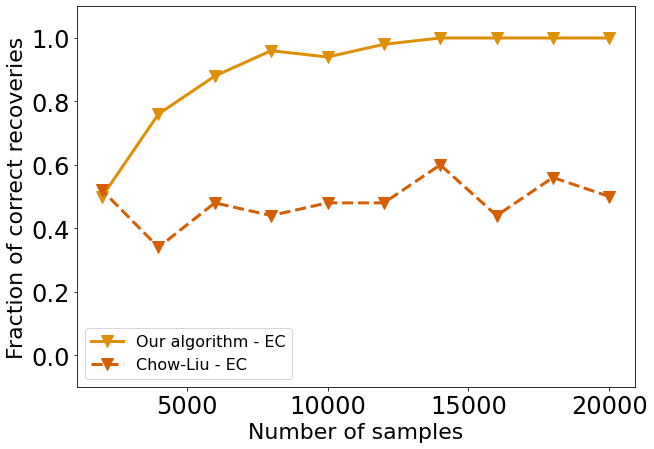

In [ ]:
results = main()